In [1]:
import os
import numpy as np
from PIL import Image
from collections import defaultdict
from tqdm import tqdm

DATASET_PATH = "./raw-img"   # napr. "./10-animals/"

# --- STORAGE ---
class_counts = defaultdict(int)
formats = defaultdict(int)
widths, heights = [], []
corrupted = []
total_size_bytes = 0

# --- ITERATE THROUGH ALL SUBFOLDERS ---
print("Analyzing dataset...\n")

for cls in sorted(os.listdir(DATASET_PATH)):
    cls_path = os.path.join(DATASET_PATH, cls)
    if not os.path.isdir(cls_path):
        continue

    # Count per class
    images = os.listdir(cls_path)
    class_counts[cls] += len(images)

    for img_name in tqdm(images, desc=f"Processing {cls}"):
        img_path = os.path.join(cls_path, img_name)

        # Check file size
        total_size_bytes += os.path.getsize(img_path)

        # Try opening image
        try:
            with Image.open(img_path) as img:
                formats[img.format] += 1
                w, h = img.size
                widths.append(w)
                heights.append(h)

        except Exception:
            corrupted.append(img_path)

# --- SUMMARY ---
total_images = sum(class_counts.values())
total_size_mb = total_size_bytes / (1024 ** 2)
total_size_gb = total_size_bytes / (1024 ** 3)

print("\n==================== DATASET SUMMARY ====================")
print(f"Total classes: {len(class_counts)}")
print(f"Total images: {total_images}")
print(f"Total size: {total_size_mb:.2f} MB ({total_size_gb:.3f} GB)\n")

print("Images per class:")
for cls, count in class_counts.items():
    print(f"  {cls:15} {count}")

print("\nImage formats:")
for fmt, count in formats.items():
    print(f"  {fmt:10} {count}")

print("\nResolution statistics:")
print(f"  Width:  min={np.min(widths)}, max={np.max(widths)}, mean={np.mean(widths):.1f}")
print(f"  Height: min={np.min(heights)}, max={np.max(heights)}, mean={np.mean(heights):.1f}")

print("\nCorrupted files found:", len(corrupted))
if corrupted:
    for c in corrupted[:10]:
        print("  ", c)
    if len(corrupted) > 10:
        print(f"  ... and {len(corrupted)-10} more")

print("==========================================================")


Analyzing dataset...



Processing squirrel: 100%|██████████| 1862/1862 [00:08<00:00, 208.50it/s]


==================== DATASET SUMMARY ====================
Total classes: 10
Total images: 26179
Total size: 585.89 MB (0.572 GB)

Images per class:
  butterfly       2112
  cat             1668
  chicken         3098
  cow             1866
  dog             4863
  elephant        1446
  horse           2623
  sheep           1820
  spider          4821
  squirrel        1862

Image formats:
  JPEG       26128
  PNG        51

Resolution statistics:
  Width:  min=60, max=6720, mean=320.0
  Height: min=57, max=6000, mean=252.6

Corrupted files found: 0


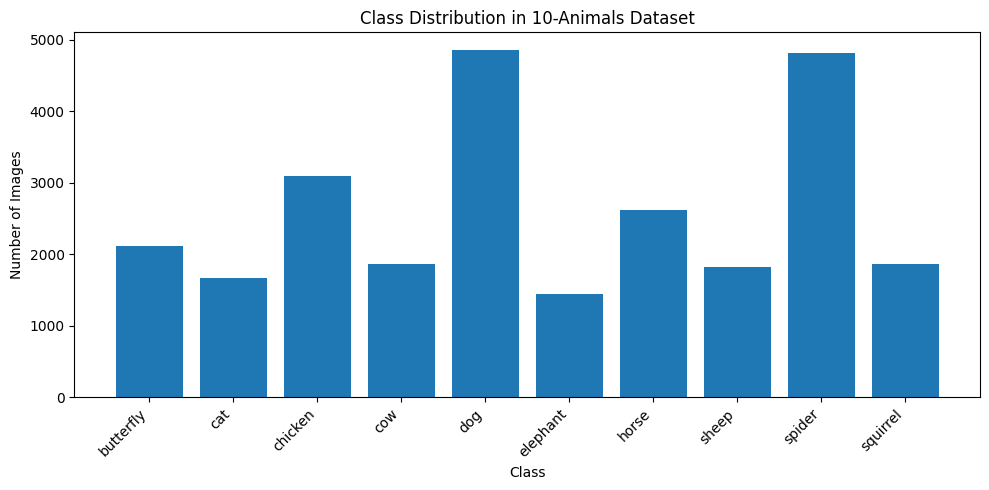

In [2]:
import matplotlib.pyplot as plt

# Convert class_counts dict → sorted lists
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]

plt.figure(figsize=(10, 5))
plt.bar(classes, counts)

plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in 10-Animals Dataset")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [1]:
import os
from PIL import Image, ImageFilter
from tqdm import tqdm
import imagehash
import numpy as np

# ==== CONFIG ====
SOURCE_DIR = "./raw-img"             # pôvodný dataset
TARGET_DIR = "filtered-img-128"  # nový dataset
MIN_SIZE = 100                       # min. šírka & výška
RESIZE_TO = (128, 128)               # cieľové rozlíšenie
MIN_BLUR_VAR = 25                    # Laplacian variance threshold
MIN_ASPECT = 0.5                     # aspect ratio min
MAX_ASPECT = 2.0                     # aspect ratio max
# =================

os.makedirs(TARGET_DIR, exist_ok=True)

# Pre deduplikáciu
global_hashes = set()

stats = {
    "processed": 0,
    "saved": 0,
    "skipped_small": 0,
    "skipped_corrupted": 0,
    "skipped_duplicates": 0,
    "skipped_blur": 0,
    "skipped_aspect": 0,
}

print("Starting dataset cleaning...\n")

# Laplacian blur detection function
def laplacian_variance(img):
    arr = np.array(img.convert("L"))
    lap = Image.fromarray(arr).filter(ImageFilter.FIND_EDGES)
    lap_var = np.var(lap)
    return lap_var

# Prejdi triedy
classes = [c for c in sorted(os.listdir(SOURCE_DIR))
           if os.path.isdir(os.path.join(SOURCE_DIR, c))]

for cls in classes:
    cls_path = os.path.join(SOURCE_DIR, cls)

    # Cieľová trieda
    out_dir = os.path.join(TARGET_DIR, cls)
    os.makedirs(out_dir, exist_ok=True)

    counter = 1
    images = os.listdir(cls_path)

    for img_name in tqdm(images, desc=f"Processing {cls}", ncols=90):
        stats["processed"] += 1
        src_path = os.path.join(cls_path, img_name)

        try:
            with Image.open(src_path) as img:
                w, h = img.size

                #===Príliš malé
                if w < MIN_SIZE or h < MIN_SIZE:
                    stats["skipped_small"] += 1
                    continue

                #Aspect ratio filter
                aspect = w / h
                if aspect < MIN_ASPECT or aspect > MAX_ASPECT:
                    stats["skipped_aspect"] += 1
                    continue

                #Konverzia do RGB
                img = img.convert("RGB")

                # Blur detection
                blur_val = laplacian_variance(img)
                if blur_val < MIN_BLUR_VAR:
                    stats["skipped_blur"] += 1
                    continue

                #  Duplicity
                img_hash = imagehash.phash(img)
                if img_hash in global_hashes:
                    stats["skipped_duplicates"] += 1
                    continue
                global_hashes.add(img_hash)

                # ✔ Resize
                img = img.resize(RESIZE_TO, Image.BICUBIC)

                # ✔ Premenovanie: class_00001.jpg
                new_name = f"{cls}_{counter:05d}.jpg"
                out_path = os.path.join(out_dir, new_name)

                img.save(out_path, "JPEG", quality=95)
                counter += 1
                stats["saved"] += 1

        except Exception:
            stats["skipped_corrupted"] += 1
            continue

print("\n=== DONE ===")
print(f"Processed:             {stats['processed']}")
print(f"Saved:                 {stats['saved']}")
print(f"Skipped (small):       {stats['skipped_small']}")
print(f"Skipped (aspect):      {stats['skipped_aspect']}")
print(f"Skipped (blurred):     {stats['skipped_blur']}")
print(f"Skipped (corrupted):   {stats['skipped_corrupted']}")
print(f"Skipped (duplicates):  {stats['skipped_duplicates']}")
print(f"Output directory:      {TARGET_DIR}")


Starting dataset cleaning...



Processing squirrel: 100%|███████████████████████████| 1862/1862 [00:05<00:00, 333.93it/s]


=== DONE ===
Processed:             26179
Saved:                 24790
Skipped (small):       23
Skipped (aspect):      305
Skipped (blurred):     1
Skipped (corrupted):   0
Skipped (duplicates):  1060
Output directory:      filtered-img-128


Found classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Saved ./averages\avg_butterfly.png
Saved ./averages\avg_cat.png
Saved ./averages\avg_chicken.png
Saved ./averages\avg_cow.png
Saved ./averages\avg_dog.png
Saved ./averages\avg_elephant.png
Saved ./averages\avg_horse.png
Saved ./averages\avg_sheep.png
Saved ./averages\avg_spider.png
Saved ./averages\avg_squirrel.png
Saved ./averages\avg_dataset.png


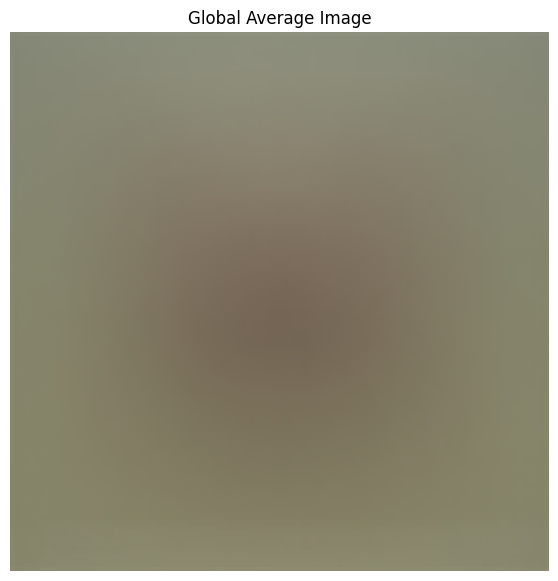

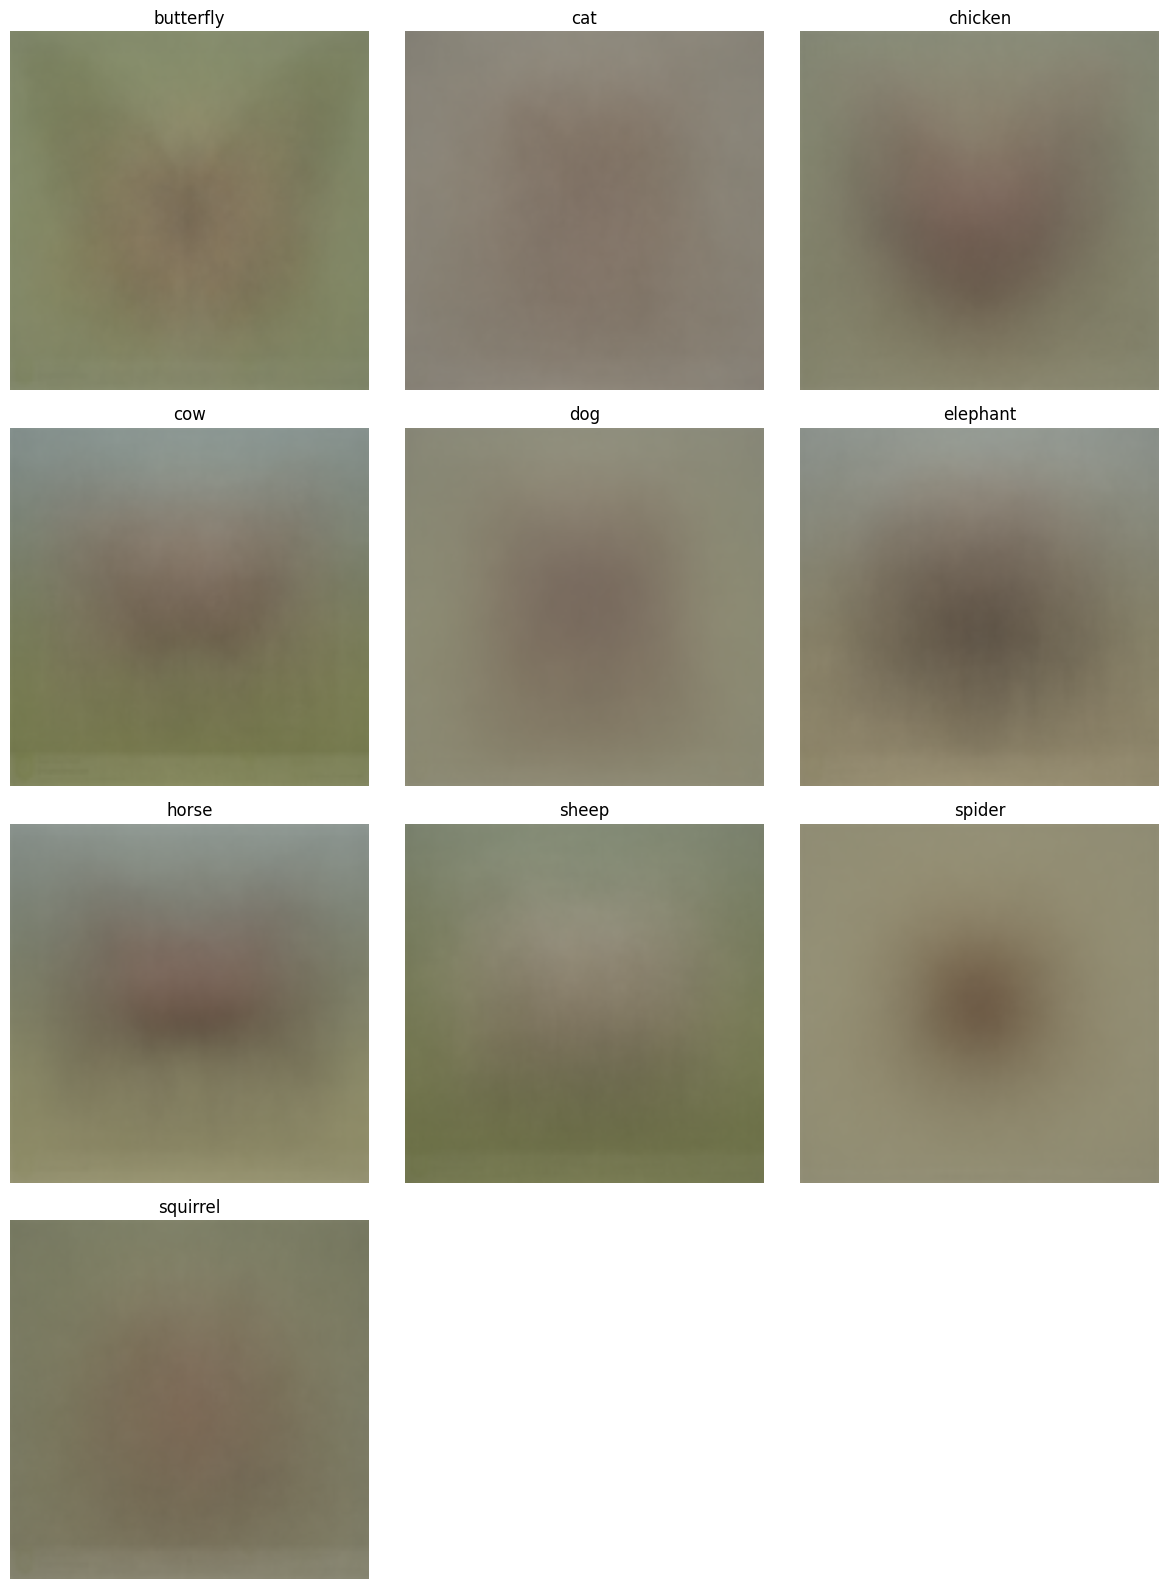

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ==============================
# 1. PATHS & SETTINGS
# ==============================
DATASET_DIR = "filtered-img-224"  # sem daj cestu ku svojmu datasetu
OUTPUT_DIR = "./averages"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# podporované formáty
VALID_EXT = {".jpg", ".jpeg", ".png"}

# ==============================
# 2. LOAD DATASET STRUCTURE
# ==============================
classes = sorted(os.listdir(DATASET_DIR))
classes = [c for c in classes if os.path.isdir(os.path.join(DATASET_DIR, c))]

print("Found classes:", classes)

# ==============================
# 3. FUNCTION TO LOAD IMAGES
# ==============================
def load_image(path, size=(128, 128)):
    """
    Loads an image, converts to RGB, resizes and returns as float32 array (0-1 range).
    """
    img = Image.open(path).convert("RGB")
    img = img.resize(size)
    return np.array(img, dtype=np.float32) / 255.0


# ==============================
# 4. COMPUTE AVERAGE IMAGE FOR EACH CLASS
# ==============================
avg_class_images = {}
all_images = []

TARGET_SIZE = (128, 128)

for class_name in classes:
    class_dir = os.path.join(DATASET_DIR, class_name)
    images = []

    for file in os.listdir(class_dir):
        if os.path.splitext(file)[1].lower() in VALID_EXT:
            img_array = load_image(os.path.join(class_dir, file), size=TARGET_SIZE)
            images.append(img_array)
            all_images.append(img_array)

    if len(images) == 0:
        print(f"⚠️ No images found for class: {class_name}")
        continue

    avg_img = np.mean(np.stack(images), axis=0)
    avg_class_images[class_name] = avg_img

    # Save file
    out_path = os.path.join(OUTPUT_DIR, f"avg_{class_name}.png")
    plt.imsave(out_path, avg_img)
    print(f"Saved {out_path}")


# ==============================
# 5. COMPUTE GLOBAL AVERAGE FOR ENTIRE DATASET
# ==============================
if len(all_images) > 0:
    global_avg = np.mean(np.stack(all_images), axis=0)

    # save
    out_path = os.path.join(OUTPUT_DIR, f"avg_dataset.png")
    plt.imsave(out_path, global_avg)
    print(f"Saved {out_path}")
else:
    print("⚠️ No images in the whole dataset!")


# ==============================
# 6. SHOW RESULTS IN NOTEBOOK
# ==============================
plt.figure(figsize=(7, 7))
plt.title("Global Average Image")
plt.imshow(global_avg)
plt.axis("off")
plt.show()

# per-class visualization
cols = 3
rows = int(np.ceil(len(avg_class_images) / cols))

plt.figure(figsize=(12, 4 * rows))
i = 1
for class_name, img in avg_class_images.items():
    plt.subplot(rows, cols, i)
    plt.title(class_name)
    plt.imshow(img)
    plt.axis("off")
    i += 1

plt.tight_layout()
plt.show()


Found classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Saved: variances\variance_butterfly.png
Saved: variances\variance_cat.png
Saved: variances\variance_chicken.png
Saved: variances\variance_cow.png
Saved: variances\variance_dog.png
Saved: variances\variance_elephant.png
Saved: variances\variance_horse.png
Saved: variances\variance_sheep.png
Saved: variances\variance_spider.png
Saved: variances\variance_squirrel.png
Saved global variance heatmap: variances\variance_dataset.png


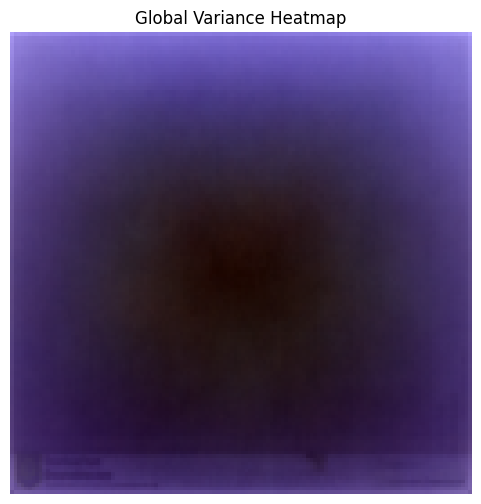

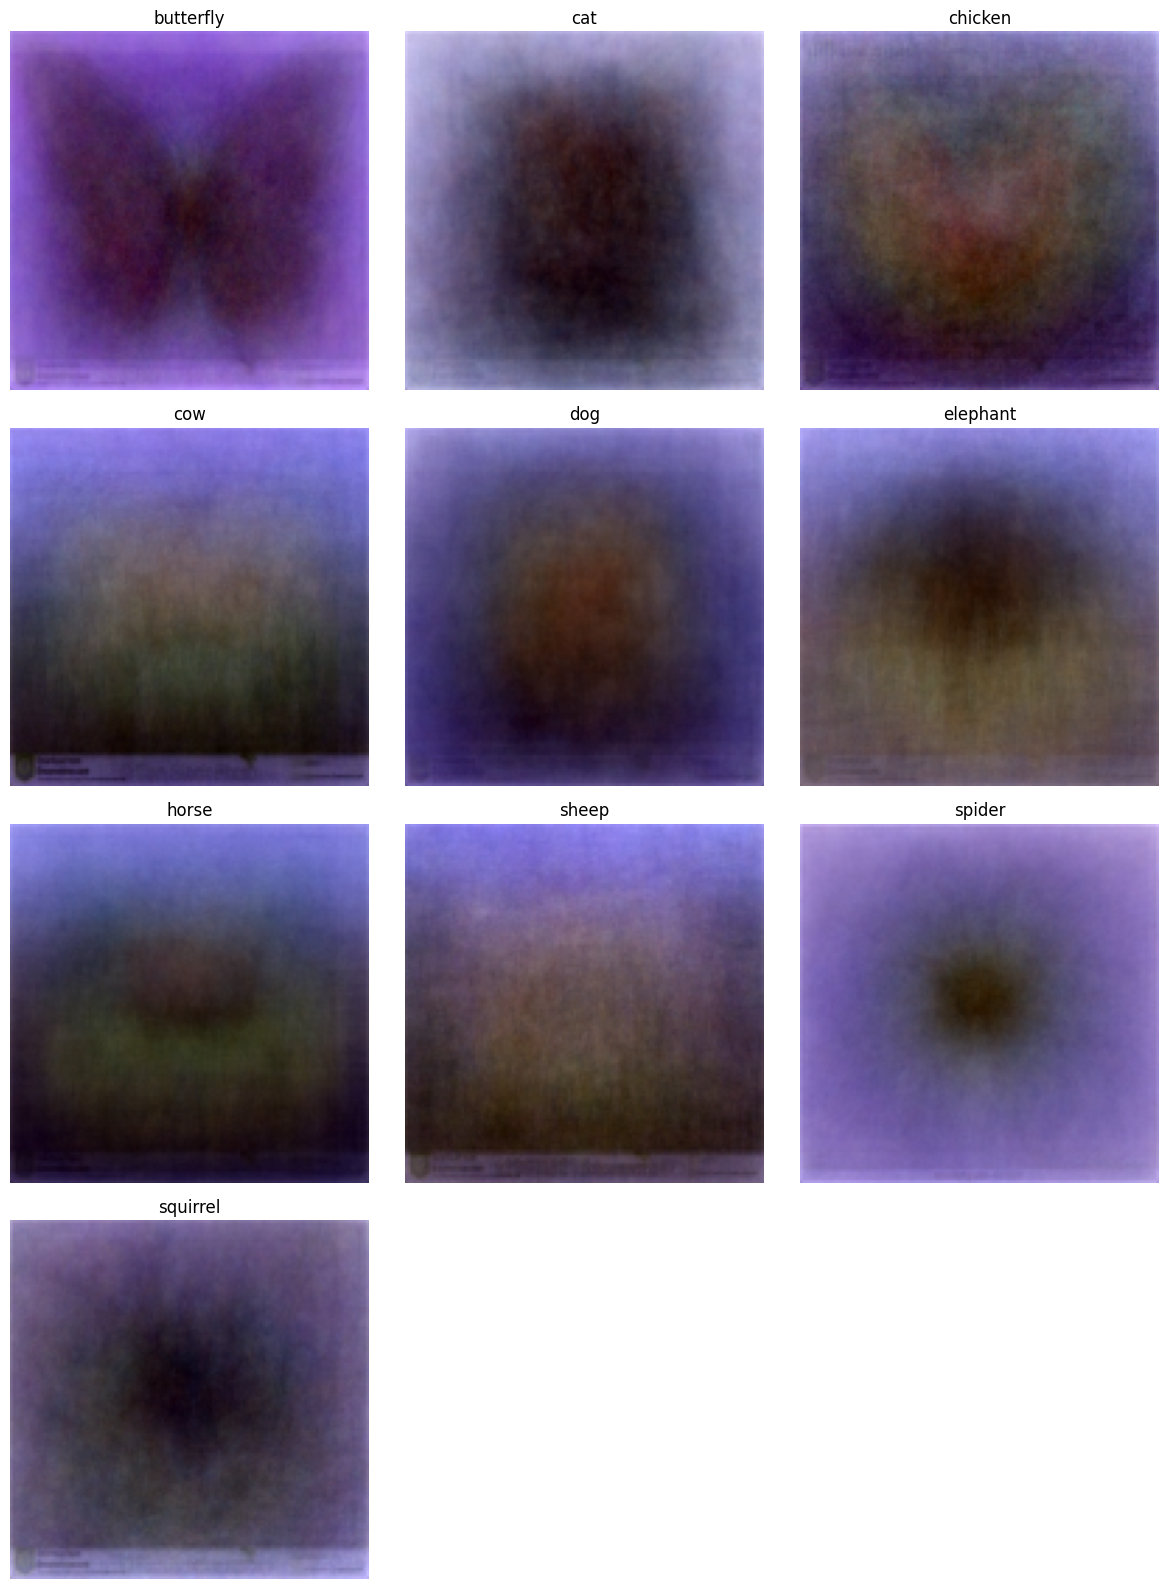

In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ========================================
# 1. SETTINGS
# ========================================
DATASET_DIR = "filtered-img-224"  # change if needed
OUTPUT_DIR = "variances"

os.makedirs(OUTPUT_DIR, exist_ok=True)

VALID_EXT = {".jpg", ".jpeg", ".png"}
TARGET_SIZE = (128, 128)  # resize images


# ========================================
# 2. IMAGE LOADER
# ========================================
def load_image(path, size=TARGET_SIZE):
    img = Image.open(path).convert("RGB")
    img = img.resize(size)
    return np.array(img, dtype=np.float32) / 255.0


# Normalize to 0–1 so we can see the heatmap
def normalize(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min + 1e-8)


# ========================================
# 3. LOAD DATASET
# ========================================
classes = sorted([
    c for c in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, c))
])

print("Found classes:", classes)

class_images = {c: [] for c in classes}
all_images = []

for class_name in classes:
    class_dir = os.path.join(DATASET_DIR, class_name)

    for f in os.listdir(class_dir):
        if os.path.splitext(f)[1].lower() in VALID_EXT:
            img = load_image(os.path.join(class_dir, f))
            class_images[class_name].append(img)
            all_images.append(img)


# ========================================
# 4. COMPUTE VARIANCE PER CLASS
# ========================================
variance_maps = {}

for class_name, imgs in class_images.items():
    if len(imgs) == 0:
        print(f"⚠️ No images in class {class_name}")
        continue

    stack = np.stack(imgs)
    variance = np.var(stack, axis=0)

    variance_maps[class_name] = variance

    # Save normalized heatmap
    out_path = os.path.join(OUTPUT_DIR, f"variance_{class_name}.png")
    plt.imsave(out_path, normalize(variance), cmap="inferno")
    print(f"Saved: {out_path}")


# ========================================
# 5. GLOBAL VARIANCE HEATMAP
# ========================================
if len(all_images) > 0:
    global_var = np.var(np.stack(all_images), axis=0)

    out_path = os.path.join(OUTPUT_DIR, "variance_dataset.png")
    plt.imsave(out_path, normalize(global_var), cmap="inferno")
    print(f"Saved global variance heatmap: {out_path}")
else:
    print("⚠️ Dataset empty!")


# ========================================
# 6. SHOW IN NOTEBOOK
# ========================================

# Show global variance
plt.figure(figsize=(6, 6))
plt.title("Global Variance Heatmap")
plt.imshow(normalize(global_var), cmap="inferno")
plt.axis("off")
plt.show()

# Show per-class variance maps
cols = 3
rows = int(np.ceil(len(classes) / cols))

plt.figure(figsize=(12, 4 * rows))
i = 1

for class_name in classes:
    plt.subplot(rows, cols, i)
    plt.title(class_name)

    heatmap = variance_maps.get(class_name, None)
    if heatmap is not None:
        plt.imshow(normalize(heatmap), cmap="inferno")
    else:
        plt.text(0.5, 0.5, "No data", ha="center")

    plt.axis("off")
    i += 1

plt.tight_layout()
plt.show()
